In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import tifffile as tf
from glob import glob
import os

from scipy import ndimage, spatial
from sklearn import neighbors

In [26]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
theta = np.linspace(-np.pi, np.pi, 50)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
ksrc = '../kde/'
dst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

sample = 'B2'
ksrc += sample + os.sep
metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col=0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')

radius = 30
maxdwall = 6
minneighs = 5
minprob = 74

In [4]:
wall = 255 - tf.imread(wsrc + 'removing_root_from_nodule.tif')[:,:,0]
wcoords = np.asarray(np.nonzero(wall > 250))
rcoords = np.asarray(np.nonzero( (wall < 250) & (wall > 50) ) )

convexhull = spatial.ConvexHull(np.flip(rcoords.T, axis=1))
hull = convexhull.points[convexhull.vertices]

# A is shape (f, d) and b is shape (f, 1).
A, b = convexhull.equations[:, :-1], convexhull.equations[:, -1:]
eps = np.finfo(np.float32).eps

def contained(x):
  # The hull is defined as all points x for which Ax + b <= 0.
  # We compare to a small positive value to account for floating
  # point issues.
  #
  # Assuming x is shape (m, d), output is boolean shape (m,).
  return np.all(np.asarray(x) @ A.T + b.T < eps, axis=1)

In [6]:
coms = metacell.loc[:, ['ndimage_comX', 'ndimage_comY']].values
inhull = contained(coms)

In [7]:
foo = metacell.loc[:, ['orig_cellID', 'orig_comX', 'orig_comY']]
foo['inhull'] = inhull
foo.to_csv(wsrc + 'inside_ring_hull.csv', index=False)

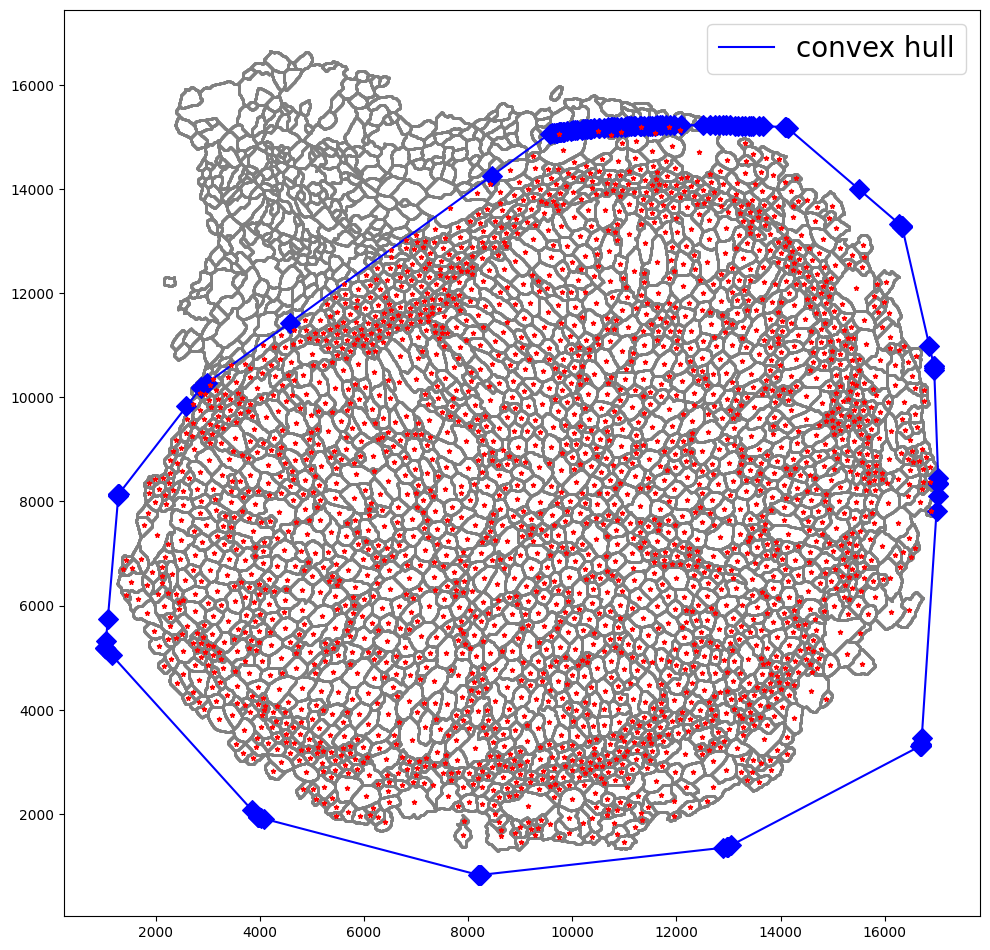

In [83]:
fs = 20
fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(wcoords[1], wcoords[0], marker='.', s=1, c='gray', zorder=1)
ax[0].plot(hull[:,0], hull[:,1], c='b', zorder=2, label='convex hull')
ax[0].scatter(hull[:,0], hull[:,1], marker='D', s=100, c='blue', zorder=3)
ax[0].scatter(coms[inhull,0], coms[inhull, 1], marker='*', s=10, c='r', zorder=4)
ax[0].legend(fontsize=fs)

ax[0].set_aspect('equal')
fig.tight_layout();

plt.savefig(wsrc + 'inside_ring_hull.png', dpi=200, format='png', bbox_inches='tight')

# Color Cell IDs

In [30]:
sample = 'B2'

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
theta = np.linspace(-np.pi, np.pi, 50)

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
csrc = '../data/'
ksrc = '../kde/'
dst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

ksrc += sample + os.sep
metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col=15)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')

radius = 30
maxdwall = 6
minneighs = 5
minprob = 74

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
css = ndimage.find_objects(label)

In [31]:
xlsxname = 'RootCellTypeAssignment'

#xlsxname = 'D2.Cell.I.D.Assignments'
data = pd.read_excel(csrc + xlsxname + '.xlsx', sheet_name=sample).drop(labels=0, axis=0)
dcolors = [ '#' + data.columns[i][:-1].split('(')[1] for i in range(data.shape[1]) ]
print(dcolors)
cmap = ListedColormap(['#bbbbbb', '#ffffff'] + dcolors)
data

['#09C8F7', '#AB24B1', '#F4C8A1', '#FB8E01', '#BB4918', '#BE9146']


,Epidermis (09C8F7),Cortex (AB24B1),Cambium (F4C8A1),Pericycle (FB8E01),Xylem (BB4918),Phloem (BE9146)
1,432.0,4,161.0,85.0,248.0,97.0
2,471.0,5,205.0,86.0,289.0,112.0
3,535.0,6,207.0,87.0,313.0,129.0
4,742.0,7,237.0,88.0,322.0,134.0
5,1068.0,8,253.0,89.0,334.0,136.0
...,...,...,...,...,...,...
221,NaN,1219,NaN,NaN,NaN,NaN
222,NaN,1221,NaN,NaN,NaN,NaN
223,NaN,1222,NaN,NaN,NaN,NaN
224,NaN,1225,NaN,NaN,NaN,NaN


In [32]:
wall = np.zeros(wallshape, dtype=int)
for i in range(data.shape[1]):
    idx =  data.loc[~pd.isna(data.iloc[:,i])].iloc[:,i].values.astype(int)
    idx = idx[idx <= metacell.iloc[-1].name ]
    
    for val in metacell.loc[list(set(idx) & set(metacell.index))]['ndimage_cellID'].values:
        wall[css[val-1]][label[css[val-1]] == val] = i+2
wall[label == 1] = 1

../cell_dams/B2_RootCellTypeAssignment.png


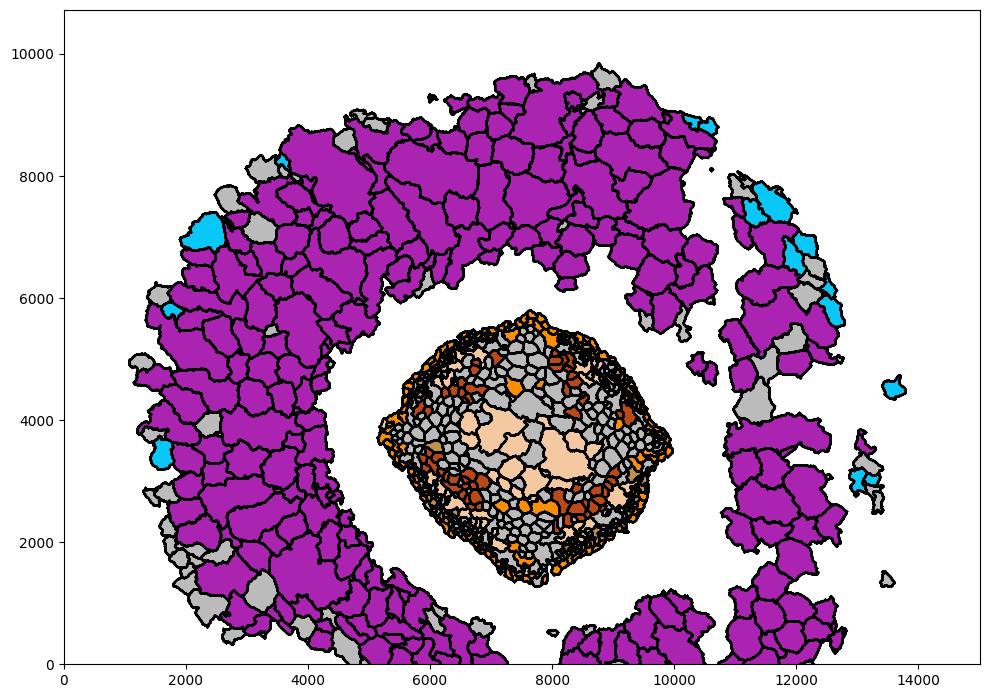

In [33]:
fs = 20
fig, ax = plt.subplots(1,1,figsize=(10,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(wall, cmap=cmap, zorder=1, origin='lower')
ax[0].scatter(wcoords[1], wcoords[0], marker='.', s=0.1, c='k', zorder=2)

ax[0].set_aspect('equal')
fig.tight_layout();
filename = wsrc + sample + '_' + xlsxname + '.png'
print(filename)
plt.savefig(filename, dpi=200, format='png', bbox_inches='tight')

In [143]:
filename = '../infected_focus_summer24/D2/infected_cells_ids'
cells = pd.read_csv(filename + '.csv')

N = 125
for i in range(10):
    cells.loc[i*N:i*N + N - 1].to_csv(filename + '_{:02d}.csv'.format(i), index=False)

# Deal with transcripts on the edge